In [226]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np

In [227]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(
    tf.config.threading.get_intra_op_parallelism_threads() or 0
)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [ ]:
# inputs
audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/Raga Malashri by Kedar Bodas.wav'

#audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/d2.wav'

output_dir = 'separated_stems'        # saved stems directory

filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir)
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.wav')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.wav')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)


Skipping separation: 'separated_stems/Raga Malashri by Kedar Bodas' already exists.
Vocals: separated_stems/Raga Malashri by Kedar Bodas/vocals.wav
Accompaniment: separated_stems/Raga Malashri by Kedar Bodas/accompaniment.wav


-------Vocal analysis--------


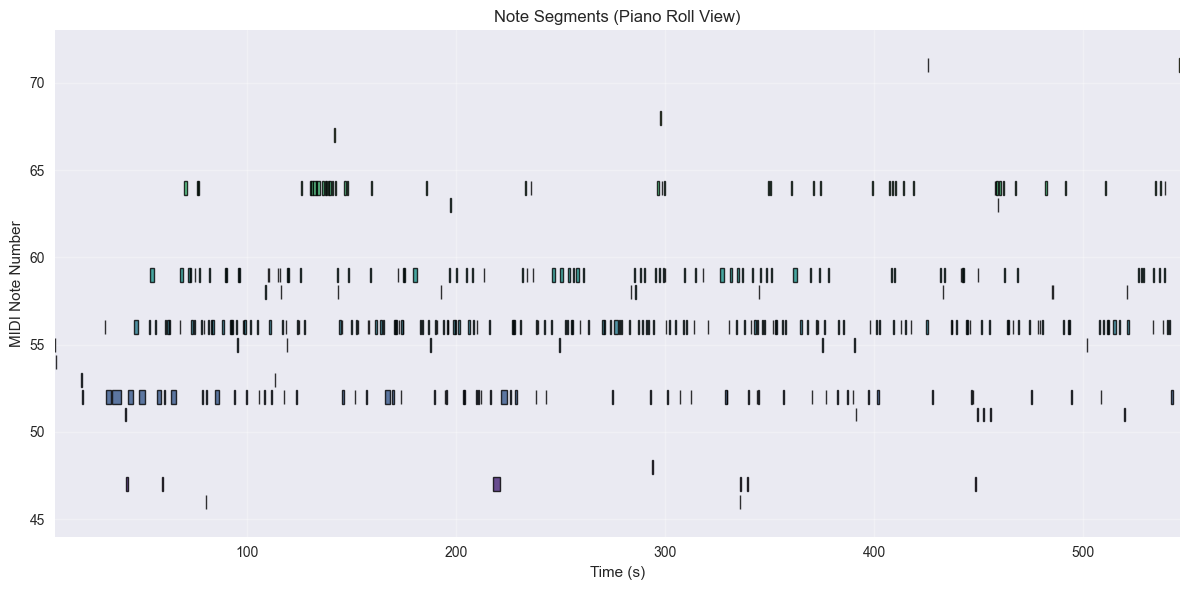

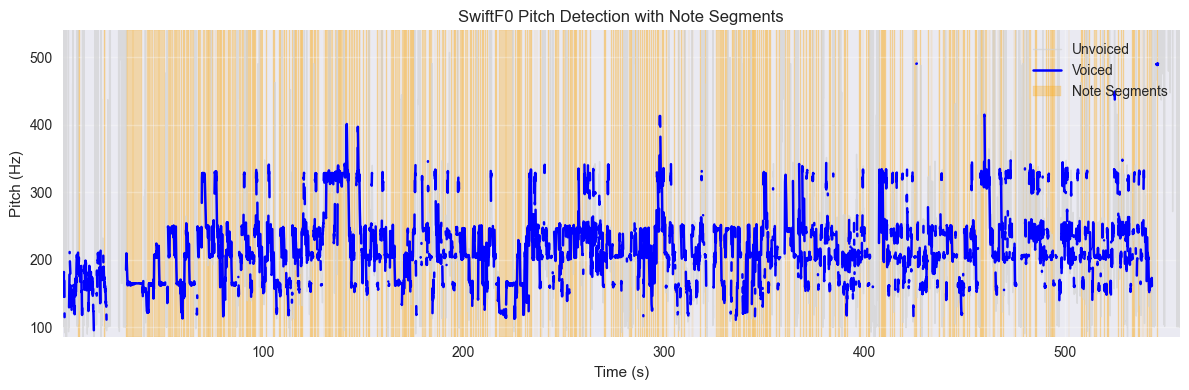

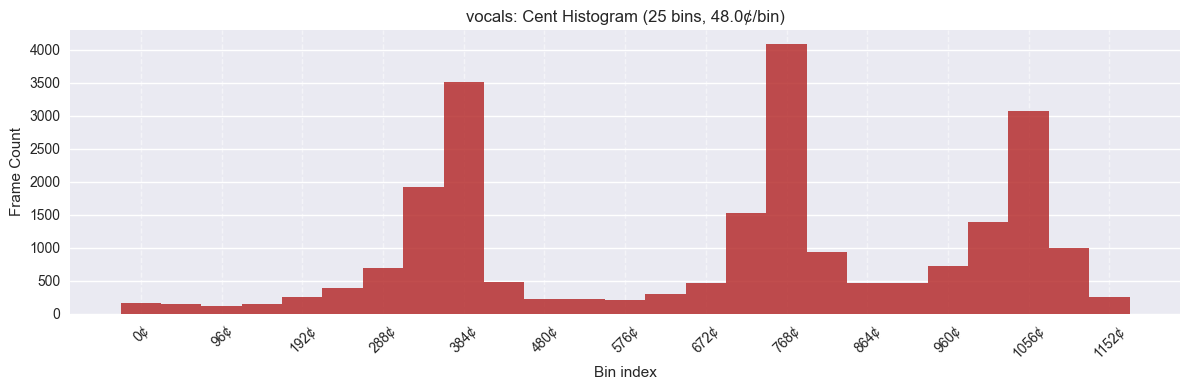

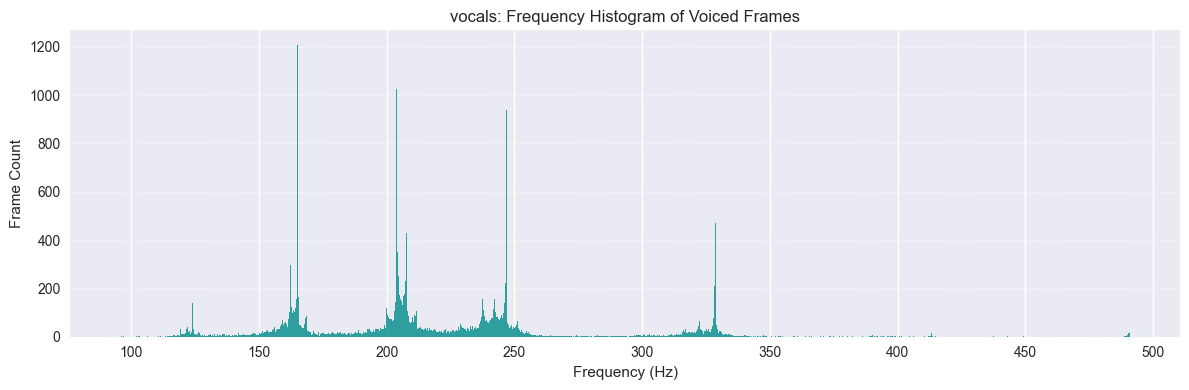

-------Accompaniment analysis --------


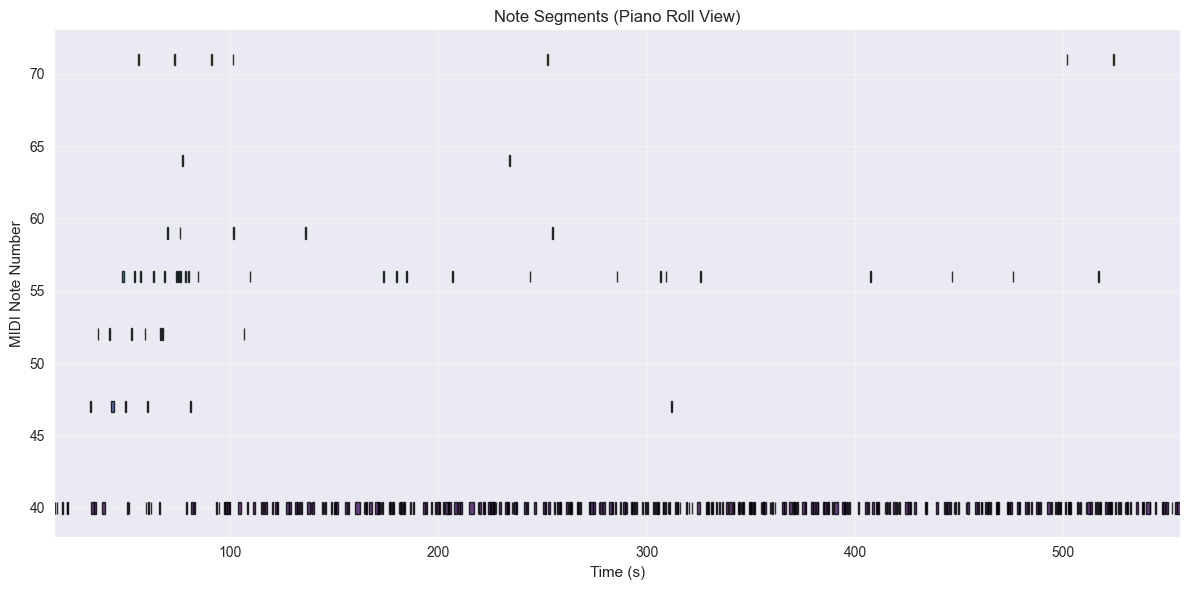

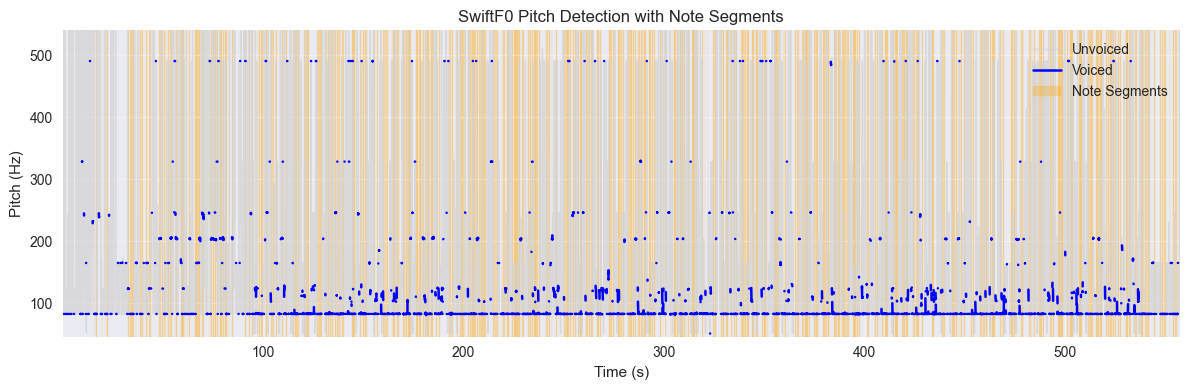

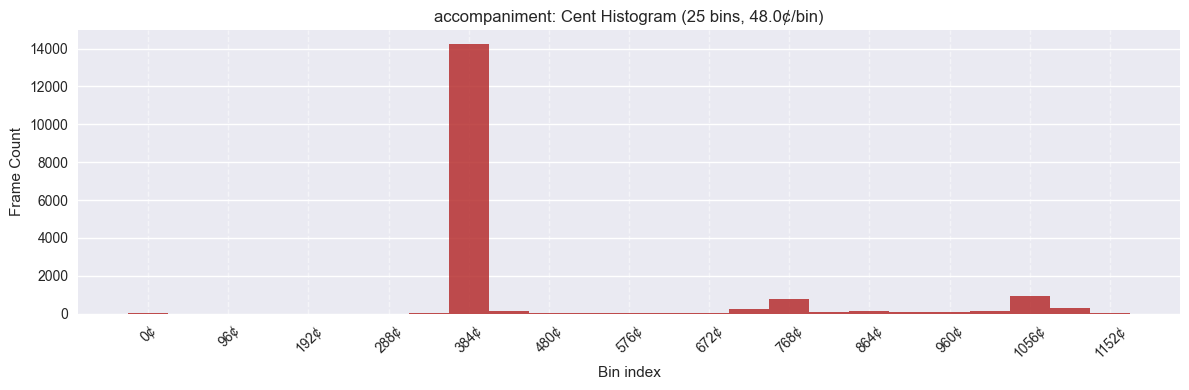

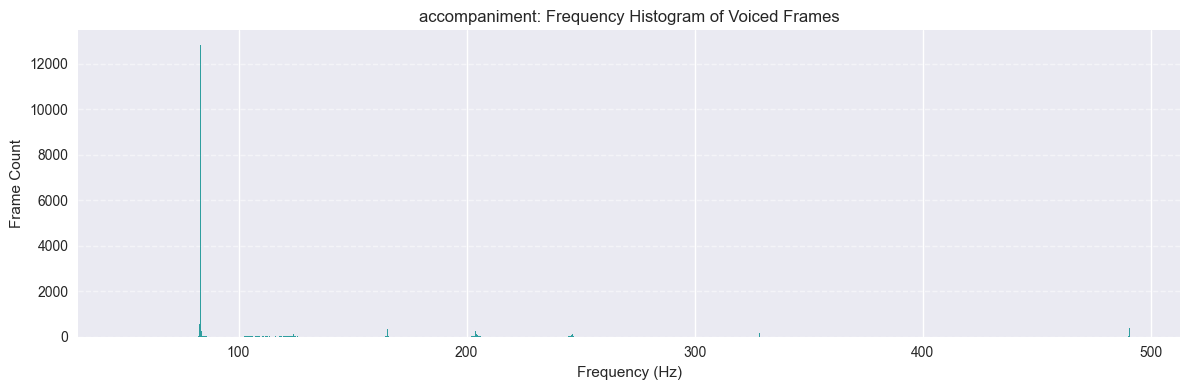

In [229]:
def analyze_audio_stem(stem_path, detector, output_prefix="output", num_bins=25):
    y, sr = librosa.load(stem_path, sr=None)
    result = detector.detect_from_array(y, sr)

    plot_pitch(result, show=False, output_path=f"{output_prefix}_pitch.jpg")
    export_to_csv(result, f"{output_prefix}_pitch_data.csv")

    notes = segment_notes(
        result,
        split_semitone_threshold=0.8,
        min_note_duration=0.25
    )
    plot_notes(notes, output_path=f"{output_prefix}_note_segments.jpg")
    plot_pitch_and_notes(result, notes, output_path=f"{output_prefix}_combined_analysis.jpg")
    export_to_midi(notes, f"{output_prefix}_notes.mid")

    voiced_frequencies = result.pitch_hz[result.voicing]
    valid_frequencies = voiced_frequencies[voiced_frequencies > 0]

    midi_vals = librosa.hz_to_midi(valid_frequencies)
    cent_values = (midi_vals % 12) * 100   # fold into one octave
    cent_hist, _ = np.histogram(cent_values, bins=num_bins, range=(0, 1200))
    bin_width = 1200 / num_bins

    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, color='firebrick', alpha=0.8)
    plt.title(f"{output_prefix}: Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Frame Count")
    # tick every semitone
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_cent_histogram.jpg")
    plt.show()

    # 6. Compute & plot frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(valid_frequencies, bins=1200, color='darkcyan', alpha=0.8)
    plt.title(f"{output_prefix}: Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Frame Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_frequency_histogram.jpg")
    plt.show()

    if output_prefix == "vocals":
        return notes, result, valid_frequencies, cent_hist
    else:
        return notes, result, valid_frequencies

min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)
detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.98)

print("-------Vocal analysis--------")
vocals_notes, result_v, valid_freqs_v, cent_hist_v = analyze_audio_stem(
    vocals_path,
    detector,
    output_prefix="vocals"
)

min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)
detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)

print("-------Accompaniment analysis --------")
accompaniment_notes, result_a, valid = analyze_audio_stem(
    accompaniment_path,
    detector,
    output_prefix="accompaniment"
)

# if accompaniment came back empty, retry with a lower confidence threshold
if not accompaniment_notes:
    print("No accompaniment notes found; lowering confidence threshold")
    fmin_hz = 65.0   
    fmax_hz = 2093.75
    detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
    accompaniment_notes, result_a, valid = analyze_audio_stem(
        accompaniment_path,
        detector,
        output_prefix="accompaniment"
    )
    if accompaniment_notes:
        print(f"retry succeeded: found {len(accompaniment_notes)} notes.")
    else:
        print("Retry still returned no notes.")

In [230]:
# extract voiced frequencies
voiced_freqs_a = result_a.pitch_hz[result_a.voicing]
valid_freqs_a  = voiced_freqs_a[voiced_freqs_a > 0]

# convert to MIDI numbers and build pitch‐class histogram 
midi_notes_a, _ = np.histogram(
    librosa.hz_to_midi(valid_freqs_a),
    bins=np.arange(129) - 0.5
)

# aggregate to 12 pitch classes
pitch_class_salience_a = np.zeros(12)
for midi_note, count in enumerate(midi_notes_a):
    pitch_class_salience_a[midi_note % 12] += count

# find 4th interval note pair with highest salience
intervals = [5, 6]  # 5 semitones = perfect fourth, 6 = augmented fourth
best_salience = 0
best_pair = (None, None)

for root_pc in range(12):
    for interval in intervals:
        other_pc = (root_pc + interval) % 12
        sal = pitch_class_salience_a[root_pc] + pitch_class_salience_a[other_pc]
        if sal > best_salience:
            best_salience = sal
            best_pair = (root_pc, other_pc)

note1, note2 = best_pair
sal1 = pitch_class_salience_a[note1]
sal2 = pitch_class_salience_a[note2]
most_saline_pc = note1 if sal1 >= sal2 else note2

western_notes = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
note1_name = western_notes[note1]
note2_name = western_notes[note2]
salient_name = western_notes[most_saline_pc]

print(f"Most salient interval pair (perfect or augmented 4th): {note1_name} and {note2_name}")
print(f"Returning more salient pitch class: {salient_name}")


Most salient interval pair (perfect or augmented 4th): B and E
Returning more salient pitch class: E


In [231]:
# assume root_name and cent_hist_v are already set

num_bins  = len(cent_hist_v)          
bin_width = 1200 / num_bins     

# make labels 
hist_labels = [
    f"{(i + 0.5) * bin_width:.0f}¢" 
    for i in range(num_bins)
]

# our standard chromatic → sargam maps
sargam_labels   = ['S','r','R','g','G','m','M','P','d','D','n','N']
root_idx        = western_notes.index(salient_name)

# find all local peaks in cent_hist_v
peaks = []
for i in range(num_bins):
    prev_i, next_i = (i - 1) % num_bins, (i + 1) % num_bins
    if cent_hist_v[i] > cent_hist_v[prev_i] and cent_hist_v[i] > cent_hist_v[next_i]:
        peaks.append(i)

print("Here's the peaks with neighbour strength:")
sargam_peaks = []
for idx in peaks:
    count     = cent_hist_v[idx]
    neigh_max = max(cent_hist_v[(idx - 1) % num_bins], cent_hist_v[(idx + 1) % num_bins])
    diff      = count - neigh_max
    ratio     = count / neigh_max if neigh_max else float('inf')

    w_label = hist_labels[idx]                   # e.g. "120¢"
    # map that back to a semitone for sargam
    midi_pc = int(round(float(w_label[:-1]) / 100)) % 12
    s_label = sargam_labels[(midi_pc - root_idx) % 12]
    sargam_peaks.append(s_label)

    print(f"  Bin {idx:2d} ({w_label}): count={count}, Δneigh={diff}, ratio={ratio:.2f}, Sargam={s_label}")

print("\nAll Sargam peaks:", sargam_peaks)


Here's the peaks with neighbour strength:
  Bin  8 (408¢): count=3517, Δneigh=1602, ratio=1.84, Sargam=S
  Bin 11 (552¢): count=228, Δneigh=11, ratio=1.05, Sargam=R
  Bin 16 (792¢): count=4091, Δneigh=2568, ratio=2.69, Sargam=G
  Bin 22 (1080¢): count=3078, Δneigh=1682, ratio=2.20, Sargam=P

All Sargam peaks: ['S', 'R', 'G', 'P']


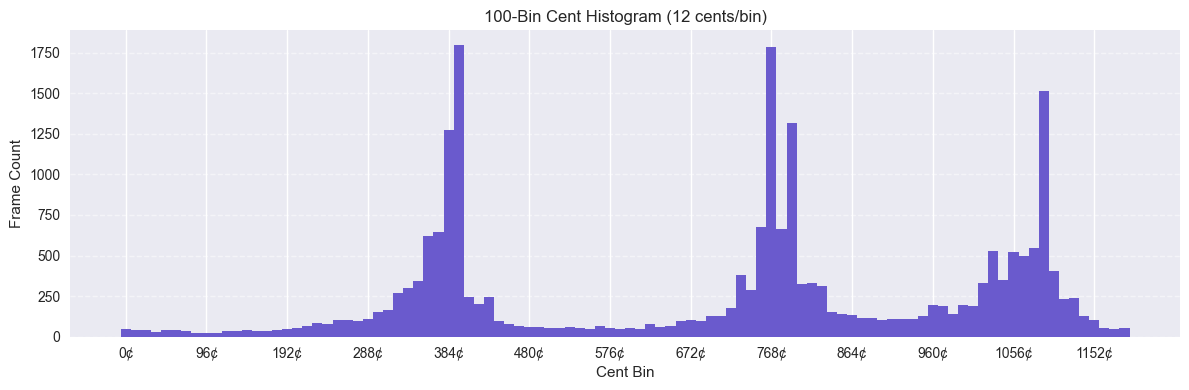

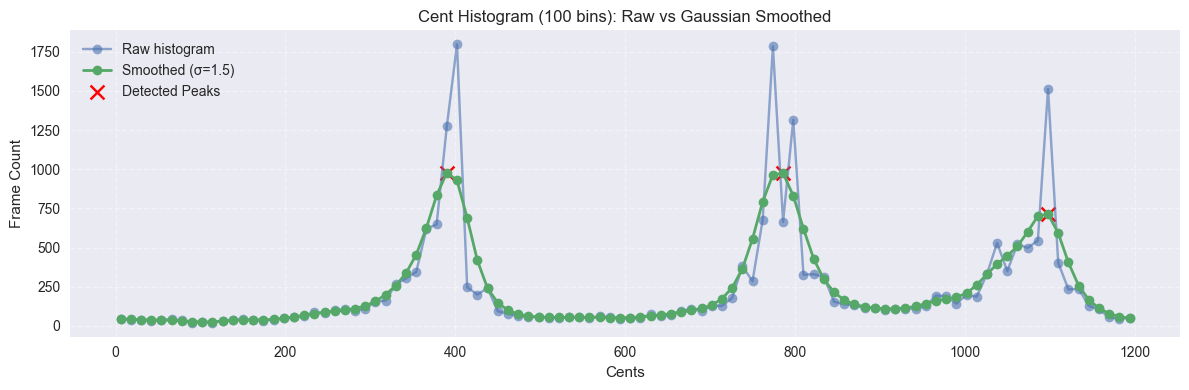

Peaks in smoothed 100-bin cent histogram:
  Bin 32 → 390.0¢ (rounded = E, count = 978.0)
  Bin 65 → 786.0¢ (rounded = G#, count = 974.0)
  Bin 91 → 1098.0¢ (rounded = B, count = 715.0)

Detected notes: ['E', 'G#', 'B']


In [232]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

num_bins = 100           # Adjust bin resolution 
sigma = 1.5              # Smoothing amount

# --- convert vocal frequencies to cents within octave ---
midi_vals = librosa.hz_to_midi(valid_freqs_v)
cent_vals = (midi_vals % 12) * 100   # Fold into [0, 1200)

# --- create cent histogram ---
cent_hist, bin_edges = np.histogram(cent_vals, bins=num_bins, range=(0, 1200))
bin_width = 1200 / num_bins

# --- plot raw cent histogram ---
plt.figure(figsize=(12, 4))
plt.bar(np.arange(num_bins), cent_hist, width=1.0, color='slateblue')
plt.title(f"{num_bins}-Bin Cent Histogram ({int(bin_width)} cents/bin)")
plt.xlabel("Cent Bin")
plt.ylabel("Frame Count")
plt.xticks(
    ticks=np.arange(0, num_bins, num_bins // 12),
    labels=[f"{int(i * bin_width)}¢" for i in range(0, num_bins, num_bins // 12)]
)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- apply gaussian smoothing with circular wraparound ---
smoothed = gaussian_filter1d(cent_hist, sigma=sigma, mode='wrap')

# --- detect local peaks (with wraparound) ---
peaks = []
for i in range(num_bins):
    prev_i = (i - 1) % num_bins
    next_i = (i + 1) % num_bins
    if smoothed[i] > smoothed[prev_i] and smoothed[i] > smoothed[next_i]:
        peaks.append(i)

cent_values = (np.arange(num_bins) + 0.5) * bin_width
plt.figure(figsize=(12, 4))
plt.plot(cent_values, cent_hist, '-o', label='Raw histogram', alpha=0.6)
plt.plot(cent_values, smoothed, '-o', label=f'Smoothed (σ={sigma})', linewidth=2)
plt.scatter(cent_values[peaks], smoothed[peaks], s=100, color='red', marker='x', label='Detected Peaks')
plt.title(f"Cent Histogram ({num_bins} bins): Raw vs Gaussian Smoothed")
plt.xlabel("Cents")
plt.ylabel("Frame Count")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

western_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
detected_notes = []

print(f"Peaks in smoothed {num_bins}-bin cent histogram:")
for idx in peaks:
    cents = (idx + 0.5) * bin_width
    rounded_cents = int(round(cents / 100.0)) % 12
    note = western_notes[rounded_cents]
    detected_notes.append(note)
    print(f"  Bin {idx:2d} → {cents:.1f}¢ (rounded = {note}, count = {smoothed[idx]:.1f})")

# --- Final output array ---
print("\nDetected notes:", detected_notes)


In [233]:
root_idx        = western_notes.index(salient_name)

detected_sargams = []
for note in detected_notes:
    pc_note = note.replace('.5', '')  # ensure .5 notes are cleaned if present
    if pc_note not in western_notes:
        continue
    pc = western_notes.index(pc_note)
    rel_idx = (pc - root_idx) % 12
    sargam = sargam_labels[rel_idx]
    detected_sargams.append(sargam)

final_list = sorted(set(detected_sargams) & set(sargam_peaks), key=lambda x: sargam_labels.index(x))

# --- Output ---
print("\nFinal intersection:", final_list)



Final intersection: ['S', 'G', 'P']


In [234]:
sargam_vector = [0] * 12
for sargam_note in final_list:
    # 3. Find the index of the sargam note in the canonical list.
    if sargam_note in sargam_labels:
        idx = sargam_labels.index(sargam_note)
        # 4. Set the corresponding position in the vector to 1.
        sargam_vector[idx] = 1

print("Final Sargam Vector:", sargam_vector)

Final Sargam Vector: [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [235]:
import csv

def find_matching_ragas(vector_to_find, csv_filepath):
    """
    Searches a raga CSV for:
      – exact matches
      – ragas that have exactly one extra note
      – ragas that have exactly one missing note

    Args:
        vector_to_find (list): 12-element binary sargam vector.
        csv_filepath (str): path to processed raga CSV.

    Returns:
        dict: {
            'exact': [...],
            'superset_one_extra': [...],
            'subset_one_missing': [...]
        }
    """
    matches = {
        "exact": [],
        "superset_one_extra": [],
        "subset_one_missing": []
    }
    n = sum(vector_to_find)

    try:
        with open(csv_filepath, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # skip header

            for row in reader:
                if len(row) < 13:
                    continue
                try:
                    raga_vector = [int(x) for x in row[:12]]
                except ValueError:
                    continue

                # exact match?
                if raga_vector == vector_to_find:
                    matches["exact"].append(row[12])
                    continue

                s = sum(raga_vector)

                # superset: one extra note
                if s == n + 1 and all(raga_vector[i] >= vector_to_find[i] for i in range(12)):
                    matches["superset_one_extra"].append(row[12])
                    continue

                # subset: one missing note
                if s == n - 1 and all(raga_vector[i] <= vector_to_find[i] for i in range(12)):
                    matches["subset_one_missing"].append(row[12])

    except FileNotFoundError:
        print(f"Error: file not found: {csv_filepath}")
        return None
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None

    return matches

found_ragas = find_matching_ragas(sargam_vector, csv_filepath='/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/raga_hash_table_processed.csv')

if not found_ragas:
    print("Could not perform raga search due to an error.")
else:
    # exact
    if found_ragas["exact"]:
        print(f"\nExact matches ({len(found_ragas['exact'])}):")
        for name in found_ragas["exact"]:
            print("  -", name)
    else:
        print("\nNo exact matches.")

    # extra
    if found_ragas["superset_one_extra"]:
        print(f"\nSuperset (+1 note) matches ({len(found_ragas['superset_one_extra'])}):")
        for name in found_ragas["superset_one_extra"]:
            print("  -", name)
    else:
        print("\nNo superset (+1) matches.")

    # missing
    if found_ragas["subset_one_missing"]:
        print(f"\nSubset (−1 note) matches ({len(found_ragas['subset_one_missing'])}):")
        for name in found_ragas["subset_one_missing"]:
            print("  -", name)
    else:
        print("\nNo subset (−1) matches.")



Exact matches (1):
  - ["Malashree"]

Superset (+1 note) matches (1):
  - [“Deshkar”]

No subset (−1) matches.
